<a href="https://colab.research.google.com/github/PHMark/ML-Personal-Projects/blob/master/Stack_Overflow_Auto_Tagging/Stack_Overflow_Auto_Tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stack Overflow: Tag Prediction

# 0. Importing Modules

In [0]:
import sqlite3
import os
import csv
import re
import time

from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

STACK_OVERFLOW_DIR = r'/content/drive/My Drive/ML Projects/Stack Overflow Tag Prediction/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Business Problem

## 1.1 Description

<p style='font-size:18px'><b> Description </b></p>
<p>
Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.<br />
<br />
Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.<br />
<br />
</p>

<p style='font-size:18px'><b> Problem Statemtent </b></p>
Suggest the tags based on the content that was there in the question posted on Stackoverflow.

## 1.2 Source

Data Source : https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data <br>
Research paper : https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tagging-1.pdf <br>
Research paper : https://dl.acm.org/citation.cfm?id=2660970&dl=ACM&coll=DL

## 1.3 Real World / Business Objectives and Constraints

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

# 2. Machine Learning problem

## 2.1 Data

### 2.1.1 Data Overview


Refer: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data
<br>
All of the data is in 2 files: Train and Test.<br />
<pre>
<b>Train.csv</b> contains 4 columns: Id,Title,Body,Tags.<br />
<b>Test.csv</b> contains the same columns but without the Tags, which you are to predict.<br />
<b>Size of Train.csv</b> - 6.75GB<br />
<b>Size of Test.csv</b> - 2GB<br />
<b>Number of rows in Train.csv</b> = 6034195<br />
</pre>
The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).<br />
<br />


<b>Data Field Explaination</b>

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br />

### 2.1.2 Example Data point

<pre>
<b>Title</b>:  Implementing Boundary Value Analysis of Software Testing in a C++ program?
<b>Body </b>: <pre><code>
        #include&lt;
        iostream&gt;\n
        #include&lt;
        stdlib.h&gt;\n\n
        using namespace std;\n\n
        int main()\n
        {\n
                 int n,a[n],x,c,u[n],m[n],e[n][4];\n         
                 cout&lt;&lt;"Enter the number of variables";\n         cin&gt;&gt;n;\n\n         
                 cout&lt;&lt;"Enter the Lower, and Upper Limits of the variables";\n         
                 for(int y=1; y&lt;n+1; y++)\n         
                 {\n                 
                    cin&gt;&gt;m[y];\n                 
                    cin&gt;&gt;u[y];\n         
                 }\n         
                 for(x=1; x&lt;n+1; x++)\n         
                 {\n                 
                    a[x] = (m[x] + u[x])/2;\n         
                 }\n         
                 c=(n*4)-4;\n         
                 for(int a1=1; a1&lt;n+1; a1++)\n         
                 {\n\n             
                    e[a1][0] = m[a1];\n             
                    e[a1][1] = m[a1]+1;\n             
                    e[a1][2] = u[a1]-1;\n             
                    e[a1][3] = u[a1];\n         
                 }\n         
                 for(int i=1; i&lt;n+1; i++)\n         
                 {\n            
                    for(int l=1; l&lt;=i; l++)\n            
                    {\n                 
                        if(l!=1)\n                 
                        {\n                    
                            cout&lt;&lt;a[l]&lt;&lt;"\\t";\n                 
                        }\n            
                    }\n            
                    for(int j=0; j&lt;4; j++)\n            
                    {\n                
                        cout&lt;&lt;e[i][j];\n                
                        for(int k=0; k&lt;n-(i+1); k++)\n                
                        {\n                    
                            cout&lt;&lt;a[k]&lt;&lt;"\\t";\n               
                        }\n                
                        cout&lt;&lt;"\\n";\n            
                    }\n        
                 }    \n\n        
                 system("PAUSE");\n        
                 return 0;    \n
        }\n
        </code></pre>\n\n
        <p>The answer should come in the form of a table like</p>\n\n
        <pre><code>       
        1            50              50\n       
        2            50              50\n       
        99           50              50\n       
        100          50              50\n       
        50           1               50\n       
        50           2               50\n       
        50           99              50\n       
        50           100             50\n       
        50           50              1\n       
        50           50              2\n       
        50           50              99\n       
        50           50              100\n
        </code></pre>\n\n
        <p>if the no of inputs is 3 and their ranges are\n
        1,100\n
        1,100\n
        1,100\n
        (could be varied too)</p>\n\n
        <p>The output is not coming,can anyone correct the code or tell me what\'s wrong?</p>\n'
<b>Tags </b>: 'c++ c'
</pre>

## 2.2 Mapping the real-world problem to a Machine Learning Problem

### 2.2.1 Type of Machine Learning Problem

<p> It is a multi-label classification problem  <br>
<b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. <br>
<b>Credit</b>: http://scikit-learn.org/stable/modules/multiclass.html
</p>

### 2.2.2 Performance metric

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://www.kaggle.com/wiki/HammingLoss <br>

# 3. Exploratory Data Analysis
Because the dataset contains huge amount of data (~7gb). As a workaround to save a space in my google drive, I've already done deduplication into it on my own computer and save the reduced file into database.sqlite file.

### 3.1.1 Using Pandas with SQLite to Load the data

In [0]:
# Function for pulling data from the database
def get_df_from_db(query):
  connected = False
  while not connected:
    try:
      con = sqlite3.connect(STACK_OVERFLOW_DIR + 'database.sqlite')
      con.text_factory = lambda b: b.decode(errors = 'ignore')
      connected = True
    except Exception as e:
      print('Connection Failed, retrying connection...')
      connected = False
    
  try:
    _df = pd.read_sql_query(query, con)
  except:
    print('An error occured while running the query')
    con.close()
    return

  con.close()
  return _df

In [0]:
df_questions = get_df_from_db('SELECT id, title, body FROM Questions')
df_tags = get_df_from_db('SELECT Id, GROUP_CONCAT(LOWER(Tag), " ") AS Tags FROM Tags GROUP BY Id')
df_all = pd.merge(left=df_questions, right=df_tags, how='inner', on='Id')
print('Rows: {}\nColumns: {}'.format(*df_all.shape))

Rows: 85085
Columns: 4


In [0]:
df_all.head()

,Id,Title,Body,Tags
0,6,The Two Cultures: statistics vs. machine learn...,"<p>Last year, I read a blog post from <a href=...",machine-learning
1,21,Forecasting demographic census,<p>What are some of the ways to forecast demog...,forecasting population census
2,22,Bayesian and frequentist reasoning in plain En...,<p>How would you describe in plain English the...,bayesian frequentist
3,31,What is the meaning of p values and t values i...,<p>After taking a statistics course and then t...,hypothesis-testing t-test p-value interpretati...
4,36,Examples for teaching: Correlation does not me...,"<p>There is an old saying: ""Correlation does n...",correlation teaching


In [0]:
df_all.isna().sum(axis=0)

Id       0
Title    0
Body     0
Tags     0
dtype: int64

## 3.2 Analysis of Tags 

### 3.2.1 Total number of unique tags

In [0]:
# Get all tags 
tags = df_all[['Tags']]
tags.head()

,Tags
0,machine-learning
1,forecasting population census
2,bayesian frequentist
3,hypothesis-testing t-test p-value interpretati...
4,correlation teaching


In [0]:
vectorizer = CountVectorizer(tokenizer=lambda x: x.split())
vectorized_tags = vectorizer.fit_transform(tags['Tags'])

In [0]:
print('Total Number of Unique Tags: ', vectorized_tags.shape[1])

Total Number of Unique Tags:  1315


In [0]:
tag_names = vectorizer.get_feature_names()
print('Sample Tags (First 10): ', tag_names[:10])
print('Sample Tags (Last 10): ', tag_names[-10:-1])

Sample Tags (First 10):  ['2d', '2sls', 'ab-test', 'abbreviation', 'abc', 'absolute-deviation', 'absolute-risk', 'academia', 'accuracy', 'active-learning']
Sample Tags (Last 10):  ['word2vec', 'xgboost', 'xorshift', 'yates-correction', 'z-score', 'z-statistic', 'z-test', 'zero-inflated', 'zero-inflation']


### 3.2.3 Number of times a tag appeared

In [0]:
# Accessing sparse matrix's property
freqs = vectorized_tags.sum(axis=0).A1
result = dict(zip(tag_names, freqs))

In [0]:
#Saving the result into a csv file to avoid memory error.
if not os.path.isfile(STACK_OVERFLOW_DIR + 'tag_counts_dict_dtm.csv'):
  with open(STACK_OVERFLOW_DIR + 'tag_counts_dict_dtm.csv', 'w') as csv_file:
      writer = csv.writer(csv_file)
      for key, value in result.items():
          writer.writerow([key, value])
tag_df = pd.read_csv(STACK_OVERFLOW_DIR + 'tag_counts_dict_dtm.csv', names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,2d,1
1,2sls,66
2,ab-test,107
3,abbreviation,4
4,abc,19


In [0]:
tag_df_sorted = tag_df.sort_values(by='Counts', ascending=False)
tag_counts = tag_df_sorted['Counts'].values
tag_df_sorted.head(5)

,Tags,Counts
986,r,13236
1020,regression,10959
669,machine-learning,6089
1220,time-series,5559
946,probability,4217


Let's plot these tags to see their distribution.

In [0]:
# Plotting the distribution of tag counts
def plot_distribution(counts, title, log_scale=False):
  plt.figure(figsize=(9, 4))
  plt.title(title)
  if log_scale:
    plt.yscale('log')
  plt.grid(True)
  plt.plot(counts)
  plt.show()


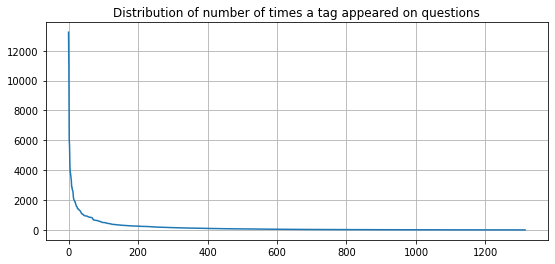

Values:  [13236  1533   937   654   496   375   317   277   253   228   198   174
   154   137   124   114   102    91    84    75    70    62    57    50
    45    41    37    33    30    28    25    23    21    20    18    16
    14    13    12    10    10     9     8     7     6     5     4     4
     3     2     2     1     1]


In [0]:
plot_distribution(tag_counts, 'Distribution of number of times a tag appeared on questions')
print('Values: ', tag_counts[:10000:25])

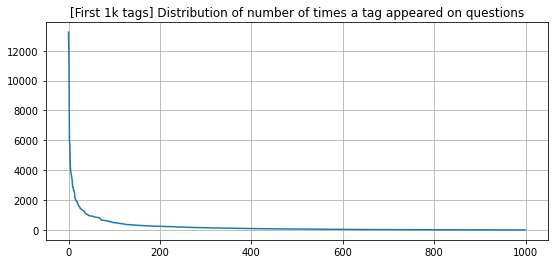

Values:  [13236  3869  2871  2054  1776  1533  1344  1209  1057   966   937   898
   860   837   745   654   635   617   569   514   496   480   450   431
   407   375   370   358   340   332   317   310   302   295   288   277
   270   266   260   256   253   245   240   236   232   228   226   217
   206   200   198   191   185   180   177   174   172   165   162   156
   154   151   148   144   139   137   134   131   128   127   124   122
   120   118   116   114   111   109   108   106   102    98    97    94
    92    91    90    88    87    85    84    81    79    77    76    75
    74    73    72    71    70    68    67    65    63    62    61    60
    60    58    57    56    55    53    51    50    49    48    47    46
    45    44    44    43    42    41    40    40    39    38    37    37
    35    34    33    33    32    31    31    31    30    30    29    29
    28    28    28    27    26    26    25    25    24    24    24    23
    23    23    22    22    21    21    21

In [0]:
# Zooming in, plotting the Top 1000 tags
plot_distribution(tag_counts[:1000], '[First 1k tags] Distribution of number of times a tag appeared on questions')
print('Values: ', tag_counts[:1000:5])

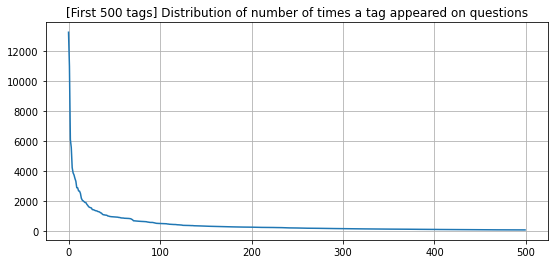

Values:  [13236  3869  2871  2054  1776  1533  1344  1209  1057   966   937   898
   860   837   745   654   635   617   569   514   496   480   450   431
   407   375   370   358   340   332   317   310   302   295   288   277
   270   266   260   256   253   245   240   236   232   228   226   217
   206   200   198   191   185   180   177   174   172   165   162   156
   154   151   148   144   139   137   134   131   128   127   124   122
   120   118   116   114   111   109   108   106   102    98    97    94
    92    91    90    88    87    85    84    81    79    77    76    75
    74    73    72    71]


In [0]:
# Zooming in, plotting the First 500 tags
plot_distribution(tag_counts[:500], '[First 500 tags] Distribution of number of times a tag appeared on questions')
print('Values: ', tag_counts[:500:5])

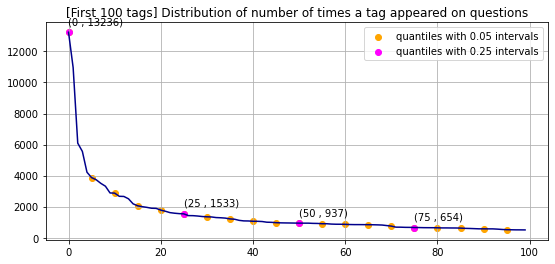

In [0]:
plt.figure(figsize=(9, 4))
plt.title('[First 100 tags] Distribution of number of times a tag appeared on questions')
plt.grid(True)
plt.plot(tag_counts[:100], color='darkblue')
plt.scatter(x=list(range(0, 100, 5)), y=tag_counts[:100:5], color='orange', label='quantiles with 0.05 intervals')
plt.scatter(x=list(range(0, 100, 25)), y=tag_counts[:100:25], color='magenta', label='quantiles with 0.25 intervals')
for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))
plt.legend()
plt.show()

In [0]:
list_tags_gt_10k = tag_df.loc[(tag_df['Counts'] > 1000), 'Tags']
list_tags_gt_1k = tag_df.loc[(tag_df['Counts'] > 500), 'Tags']

print('Tags that are used in more than 10k questions', len(list_tags_gt_10k))
print('Tags that are used in more than 1k questions', len(list_tags_gt_1k))

Tags that are used in more than 10k questions 43
Tags that are used in more than 1k questions 99


<b>Observation(s):</b>

1.) There are 43 tags which are used in more than 10k questions.

2.) There are 99 tags which are used in more than 1k questions.

3.) The distribution of number of times a tag appeared on questions was highly skewed to the left.

4.) r was the most used tag (13,236 times) across all of the questions.

5.) Since some tags occur more than the others, Micro F1 Score is an appropriate metric to use to gauge the model's precision and recall effectively.

### 3.2.4 Tags per Question

In [0]:
tag_quest_count = list(vectorized_tags.sum(axis=1).A.reshape(-1))

In [0]:
print(tag_quest_count[:5])

[1, 3, 2, 5, 2]


In [0]:
tag_quest_count_freq = np.unique(tag_quest_count, return_counts=True)

In [0]:
print('Minimum Number of Tags per Question: ', tag_quest_count_freq[0].min())
print('Maximum Number of Tags per Question: ', tag_quest_count_freq[0].max())
print('Average Number of Tags per Question: ', tag_quest_count_freq[0].mean())

Minimum Number of Tags per Question:  1
Maximum Number of Tags per Question:  5
Average Number of Tags per Question:  3.0


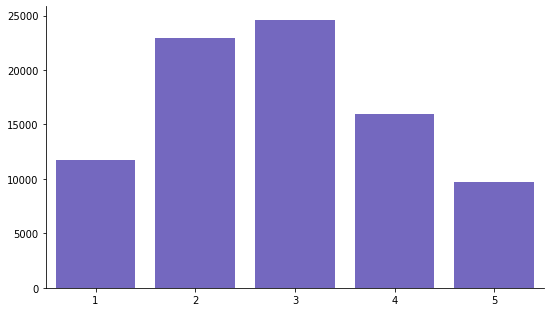

In [0]:
sns.FacetGrid('whitegrid', height=4.5, aspect=1.7)
bar = sns.barplot(x=tag_quest_count_freq[0], y=tag_quest_count_freq[1], color='slateblue')
plt.title('')
plt.show()

<b>Observation(s):</b>

1.) The minimum number of tags per question is 1.

2.) The maximum number of tags per question is 5.

3.) The mean number of tags per question is 3.

4.) Most of the questions has 2 or 3 number of tags associated with them.

### 3.2.5 Most Frequent Tags

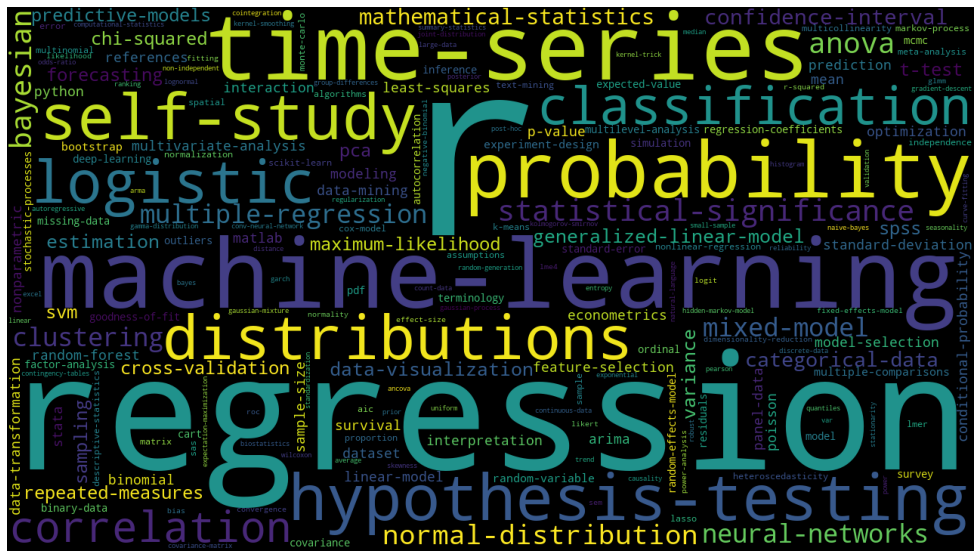

In [0]:
wordcloud = WordCloud(background_color='black', width=1280,
                      height=720).generate_from_frequencies(result)
plt.figure(figsize=(30, 10))
plt.imshow(wordcloud)
plt.axis(False)
plt.show()

<b>Observation(s):</b>
The most dominant tags (in terms of font-size) that we can observe are  r, regression, probability, & time-series.

### 3.2.5.1 Shared Word Ratio of Tag to Body/Title

In [0]:
def f1_get_total_common_words(row):
  '''Get the intersection between tag and title'''
  w1 = set(map(lambda s: s.lower().strip(), row['Title'].split()))
  w2 = set(map(lambda s: s.lower().strip(), row['Tags'].split()))
  return 1.0 * len(w1&w2)

def f1_get_total_words(row):
  '''Get the union of tag and title'''
  w1 = set(map(lambda s: s.lower().strip(), row['Title'].split()))
  w2 = set(map(lambda s: s.lower().strip(), row['Tags'].split()))
  return 1.0 * len(w1)+len(w2)

def f2_get_total_common_words(row):
  '''Get the intersection between tag and body'''
  w1 = set(map(lambda s: s.lower().strip(), row['Body'].split()))
  w2 = set(map(lambda s: s.lower().strip(), row['Tags'].split()))
  return 1.0 * len(w1&w2)

def f2_get_total_words(row):
  '''Get the union of tag and body'''
  w1 = set(map(lambda s: s.lower().strip(), row['Body'].split()))
  w2 = set(map(lambda s: s.lower().strip(), row['Tags'].split()))
  return 1.0 * len(w1)+len(w2)

In [0]:
df_all['f1_word_common'] = df_all.apply(f1_get_total_common_words, axis=1)
df_all['f1_word_total'] = df_all.apply(f1_get_total_words, axis=1)
df_all['f1_word_share'] = df_all['f1_word_common']/df_all['f1_word_total']

In [0]:
df_all['f2_word_common'] = df_all.apply(f2_get_total_common_words, axis=1)
df_all['f2_word_total'] = df_all.apply(f2_get_total_words, axis=1)
df_all['f2_word_share'] = df_all['f2_word_common']/df_all['f2_word_total']

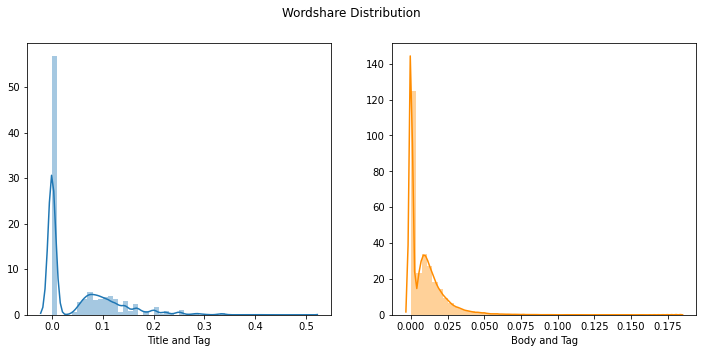

In [0]:
plt.figure(figsize=(12, 5))
plt.suptitle('Wordshare Distribution')
plt.subplot(1,2,1)
sns.distplot(a=df_all['f1_word_share'], )
plt.xlabel('Title and Tag')

plt.subplot(1,2,2)
sns.distplot(a=df_all['f2_word_share'], color='darkorange')
plt.xlabel('Body and Tag')
plt.show()

In [0]:
print(df_all['f1_word_share'].describe())
print()
print(df_all['f2_word_share'].describe())

count    85085.000000
mean         0.051366
std          0.070719
min          0.000000
25%          0.000000
50%          0.000000
75%          0.090909
max          0.500000
Name: f1_word_share, dtype: float64

count    85085.000000
mean         0.009174
std          0.012351
min          0.000000
25%          0.000000
50%          0.005988
75%          0.014085
max          0.181818
Name: f2_word_share, dtype: float64


In [0]:
print(df_all['f1_word_common'].describe())
print()
print(df_all['f2_word_common'].describe())

count    85085.000000
mean         0.536193
std          0.695407
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: f1_word_common, dtype: float64

count    85085.000000
mean         0.782112
std          0.847607
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: f2_word_common, dtype: float64


<b>Observation(s): </b>

1.) The word share values for tag & title ranges between 0 and 0.50

2.) The word share values for tag & body ranges between 0 and 0.18

3.) We can see that there are many words in common between Tag and Title. Logically, as the number of words in a question increases, the number of chances that the Tag is present on that question is higher.

4.) The word_share for Title and Tags is higher than Tags and Body. With this findings, we can try to add weights on the Title column. 


### 3.2.6 The Top 20 Tags

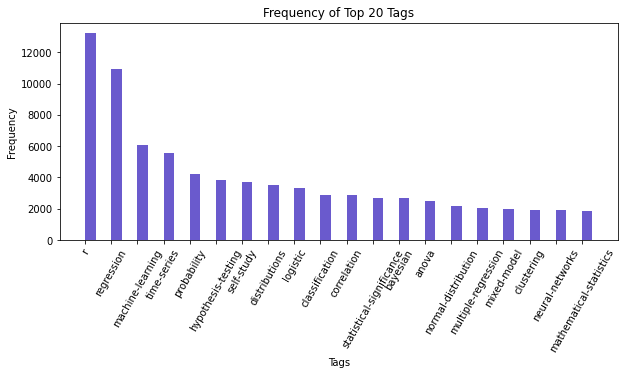

In [0]:
x = np.arange(20)
plt.figure(figsize=(10, 4))
plt.title('Frequency of Top 20 Tags')
plt.bar(tag_df_sorted['Tags'].iloc[:20], 
        height=tag_df_sorted['Counts'].iloc[:20],
        align='edge', width=0.4, color='slateblue')
plt.xticks(rotation=60)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.show()

<b>Observation(s):</b>

1.) r is the most frequent tag across all of the questions.

3.) Interestingly, there is a tag related to self-study.


## 3.3 Cleaning and preprocessing of Questions

### 3.3.1 Preprocessing


1.) Separate out code-snippets from Body

2.) Remove Special characters from Question title and description (not in code)

3.) Remove stop words (Except 'C')

4.) Remove HTML Tags

5.) Convert all the characters into small letters

6.) Use SnowballStemmer to stem the words

We will also put 3x more weight to the title of the question

In [0]:
nltk.download('stopwords')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
code_pattern = r'<code>(.*?)</code>'
b_code_pattern = rb'<code>(.*?)</code>'

def remove_html_tags(string):
  return re.sub('<.*?>', ' ', string).strip()

def remove_special_characters(string):
  string = re.sub(r'[^a-zA-Z]+', ' ', string)
  return string

def remove_code_tags(string):
  code = re.findall(r'<code>(.*?)</code>', string, flags=re.DOTALL)
  if len(code):
    return code[0]
  else:
    return 'no code'

def parse_question(string):
  question = re.sub(code_pattern, ' ', string, flags=re.DOTALL|re.MULTILINE)
  question = remove_html_tags(question)
  return question

def to_lower(string):
  return string.lower()

def tokenize(string):
  return word_tokenize(string)

def remove_stopwords(string):
  string_prime = []
  for word in tokenize(string):
    is_c = (len(word)!=1 or word=='c')
    if word not in stopwords and is_c:
      string_prime.append(stemmer.stem(word))
  return ' '.join(string_prime)

def preprocess(df):
  df['words_pre'] = len(df['Body']) + len(df['Title'])
  df['Body'] = to_lower(df['Body'])
  df['is_code'] = 'code' in df['Body']
  df['code'] = remove_code_tags(df['Body'])
  df['question'] = parse_question(df['Body'])
  # Putting 3x more weight on the title of the question
  df['question'] = (df['Title'] + ' ')*3 + df['question']
  df['question'] = remove_special_characters(df['question'])
  df['question'] = remove_stopwords(df['question'])
  df['words_post'] = len(df['question'])
  
  return df.loc[['Title', 'question', 'code', 'is_code', 'words_pre', 'words_post', 'Tags']]

In [0]:
# # Since 4 million datapoints is too large, we will randomly sample 200k datapoints for our experimentation.
# start = time.time()
# df_no_dup = get_df_from_db('SELECT title, body, tags FROM no_dup_train')
# end = time.time()
# print('Time consumed to execute the query: ', round(end-start, 3))

In [0]:
# df_no_dup = df_no_dup.sample(n=200000, random_state=42)

In [0]:
tqdm.pandas()
df_all = df_all.progress_apply(preprocess, axis=1)

In [0]:
conn = sqlite3.connect(STACK_OVERFLOW_DIR + 'Preprocessed.db')
df_all.to_sql(index=False, name='preprocessed_questions', 
                 con=conn, if_exists='replace')
conn.commit()
conn.close()

In [0]:
conn = sqlite3.connect(STACK_OVERFLOW_DIR + 'Preprocessed.db')
print(pd.read_sql('SELECT * FROM preprocessed_questions', conn).shape)
conn.close()

(85085, 7)


In [0]:
import os
if os.path.isfile(STACK_OVERFLOW_DIR + 'Preprocessed.db'):
  conn = sqlite3.connect(STACK_OVERFLOW_DIR + 'Preprocessed.db')
  df_all = pd.read_sql('SELECT * FROM preprocessed_questions', con=conn)
else: 
  print('Please download the Preprocessed.db file!')

# 4. Machine Learning Modeling

## 4.1 Converting Tags for Multi-Labels Problem

In [0]:
label_vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), binary=True)
multilabel_y = label_vectorizer.fit_transform(df_all['Tags'])

In [0]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [0]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=df_all.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

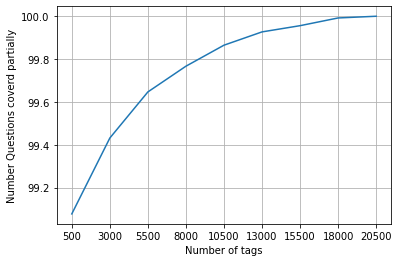

with  500 tags we are covering  99.077 % of questions


In [0]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel('Number of tags')
plt.ylabel('Number Questions coverd partially')
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power
print('with ', 500, 'tags we are covering ', questions_explained[0], '% of questions')

In [0]:
multilabel_yx = tags_to_choose(500)

## 4.2 Split the data into test and train (80:20)

In [0]:
total_size = df_all.shape[0]
train_size = int(0.80*total_size)

x_train = df_all.head(train_size)
x_test = df_all.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [0]:
print('Dimensions of Training and Test set')
print('X Train: ', x_train.shape, '\nY Train: ', y_train.shape)
print('X Test: ',x_test.shape, '\nY Test: ', y_test.shape)

Dimensions of Training and Test set
X Train:  (68068, 7) 
Y Train:  (68068, 500)
X Test:  (17017, 7) 
Y Test:  (17017, 500)


## 4.3 Featurizing data

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import joblib

In [0]:
start = time.time()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer=lambda x: x.split(), sublinear_tf=False, ngram_range=(1,4))
# if os.path.
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", time.time() - start)

Time taken to run this cell : 85.9029324054718


In [0]:
joblib.dump(x_train_multilabel, STACK_OVERFLOW_DIR + 'x_train_multilabel.pkl')
joblib.dump(y_train, STACK_OVERFLOW_DIR + 'y_train.pkl')
joblib.dump(x_test_multilabel, STACK_OVERFLOW_DIR + 'x_test_multilabel.pkl')
joblib.dump(y_test, STACK_OVERFLOW_DIR + 'y_test.pkl')

['/content/drive/My Drive/ML Projects/Stack Overflow Tag Prediction/y_test.pkl']

In [0]:
vectorizer.get_feature_names()[500:520]

In [0]:
x_train_multilabel.shape

(68068, 146633)

In [0]:
# # Save the features as pickle file
# joblib.dump(x_train_multilabel, STACK_OVERFLOW_DIR + 'x_train_multilabel.pkl')
# joblib.dump(x_test_multilabel, STACK_OVERFLOW_DIR + 'x_test_multilabel.pkl')

['/content/drive/My Drive/ML Projects/Stack Overflow Tag Prediction/x_test_multilabel.pkl']

In [0]:
x_train_multilabel = joblib.load(STACK_OVERFLOW_DIR + 'x_train_multilabel.pkl')
x_test_multilabel = joblib.load(STACK_OVERFLOW_DIR + 'x_test_multilabel.pkl')

In [0]:
def show_scores(y_true, y_pred):
  print("accuracy :",metrics.accuracy_score(y_true,y_pred))
  print("macro f1 score :",metrics.f1_score(y_true, y_pred, average = 'macro', zero_division=1))
  print("micro f1 scoore :",metrics.f1_score(y_true, y_pred, average = 'micro', zero_division=1))
  print("hamming loss :",metrics.hamming_loss(y_true,y_pred))
  print("Precision recall report :\n",metrics.classification_report(y_true, y_pred, zero_division=1))

## 4.4 Logistic Regression with Hyperparameter Tuning

In [0]:
start = time.time()
alphas = [1/(10**i) for i in range(4, 10)]
lr_params = {'estimator__alpha': alphas}

lr_clf = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'), n_jobs=3)
gridcv_lr = GridSearchCV(estimator=lr_clf, param_grid=lr_params, 
                         scoring='f1_micro', cv=5, verbose=10,
                         return_train_score=True)
gridcv_lr.fit(x_train_multilabel, y_train)
end = time.time()
print('Total runtime of 5 fold GridSearchCV: ', round(end-start, 3), ' (seconds)')

start = time.time()
gridcv_pred = gridcv_lr.predict(x_test_multilabel)
end = time.time()
print('Total runtime of Testing/Evaluation: ', round(end-start, 3), ' (seconds)')
show_scores(y_test, gridcv_pred)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] estimator__alpha=0.0001 .........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  estimator__alpha=0.0001, score=(train=0.336, test=0.339), total= 4.2min
[CV] estimator__alpha=0.0001 .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s


[CV]  estimator__alpha=0.0001, score=(train=0.335, test=0.331), total= 4.1min
[CV] estimator__alpha=0.0001 .........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.6min remaining:    0.0s


[CV]  estimator__alpha=0.0001, score=(train=0.338, test=0.326), total= 4.1min
[CV] estimator__alpha=0.0001 .........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 12.8min remaining:    0.0s


[CV]  estimator__alpha=0.0001, score=(train=0.336, test=0.335), total= 4.2min
[CV] estimator__alpha=0.0001 .........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 17.2min remaining:    0.0s


[CV]  estimator__alpha=0.0001, score=(train=0.335, test=0.334), total= 4.1min
[CV] estimator__alpha=1e-05 ..........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 21.4min remaining:    0.0s


[CV]  estimator__alpha=1e-05, score=(train=0.504, test=0.468), total= 4.3min
[CV] estimator__alpha=1e-05 ..........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 25.9min remaining:    0.0s


[CV]  estimator__alpha=1e-05, score=(train=0.504, test=0.460), total= 4.3min
[CV] estimator__alpha=1e-05 ..........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 30.4min remaining:    0.0s


[CV]  estimator__alpha=1e-05, score=(train=0.503, test=0.459), total= 4.3min
[CV] estimator__alpha=1e-05 ..........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 34.9min remaining:    0.0s


[CV]  estimator__alpha=1e-05, score=(train=0.505, test=0.462), total= 4.3min
[CV] estimator__alpha=1e-05 ..........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 39.3min remaining:    0.0s


[CV]  estimator__alpha=1e-05, score=(train=0.503, test=0.464), total= 4.3min
[CV] estimator__alpha=1e-06 ..........................................
[CV]  estimator__alpha=1e-06, score=(train=0.998, test=0.482), total= 4.8min
[CV] estimator__alpha=1e-06 ..........................................
[CV]  estimator__alpha=1e-06, score=(train=0.998, test=0.475), total= 4.7min
[CV] estimator__alpha=1e-06 ..........................................
[CV]  estimator__alpha=1e-06, score=(train=0.998, test=0.475), total= 4.7min
[CV] estimator__alpha=1e-06 ..........................................
[CV]  estimator__alpha=1e-06, score=(train=0.998, test=0.474), total= 4.7min
[CV] estimator__alpha=1e-06 ..........................................
[CV]  estimator__alpha=1e-06, score=(train=0.998, test=0.478), total= 4.7min
[CV] estimator__alpha=1e-07 ..........................................
[CV]  estimator__alpha=1e-07, score=(train=1.000, test=0.470), total= 5.1min
[CV] estimator__alpha=1e-07 .......

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 158.1min finished


Total runtime of 3 fold GridSearchCV:  9844.551  (seconds)
Total runtime of Testing/Evaluation:  2.383  (seconds)
accuracy : 0.09278956337779867
macro f1 score : 0.4110979300597982
micro f1 scoore : 0.4791012585656174
hamming loss : 0.004484926837868015
Precision recall report :
               precision    recall  f1-score   support

           0       0.58      0.45      0.51      2675
           1       0.59      0.47      0.52      2189
           2       0.49      0.34      0.41      1296
           3       0.72      0.54      0.62      1167
           4       0.51      0.38      0.44       813
           5       0.50      0.33      0.40       772
           6       0.45      0.22      0.30       748
           7       0.43      0.27      0.33       671
           8       0.79      0.62      0.69       657
           9       0.58      0.39      0.47       619
          10       0.71      0.52      0.60       582
          11       0.46      0.22      0.30       526
          12    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
# Save the best estimator
joblib.dump(gridcv_lr.best_estimator_, STACK_OVERFLOW_DIR + 'LR_BestEstimator.pkl')

['/content/drive/My Drive/ML Projects/Stack Overflow Tag Prediction/LR_BestEstimator.pkl']

In [0]:
show_scores(y_test, gridcv_pred)

accuracy : 0.09278956337779867
macro f1 score : 0.4110979300597982
micro f1 scoore : 0.4791012585656174
hamming loss : 0.004484926837868015
Precision recall report :
               precision    recall  f1-score   support

           0       0.58      0.45      0.51      2675
           1       0.59      0.47      0.52      2189
           2       0.49      0.34      0.41      1296
           3       0.72      0.54      0.62      1167
           4       0.51      0.38      0.44       813
           5       0.50      0.33      0.40       772
           6       0.45      0.22      0.30       748
           7       0.43      0.27      0.33       671
           8       0.79      0.62      0.69       657
           9       0.58      0.39      0.47       619
          10       0.71      0.52      0.60       582
          11       0.46      0.22      0.30       526
          12       0.73      0.59      0.65       524
          13       0.78      0.58      0.67       499
          14       0.5

## 4.5 Naive Bayes with Hyperparameter Tuning

In [0]:
nb_clf = OneVsRestClassifier(MultinomialNB(alpha=0.0001), n_jobs=3)
nb_clf.fit(x_train_multilabel, y_train)
nb_predictions = nb_clf.predict(x_test_multilabel)
print("accuracy :",metrics.accuracy_score(y_test,nb_predictions))
print("macro f1 score :",metrics.f1_score(y_test, nb_predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, nb_predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,nb_predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, nb_predictions))

accuracy : 0.04266321913380737
macro f1 score : 0.129075858649671
micro f1 scoore : 0.2519065530211533
hamming loss : 0.005095845331139449
Precision recall report :
               precision    recall  f1-score   support

           0       0.63      0.28      0.39      2675
           1       0.59      0.34      0.43      2189
           2       0.45      0.35      0.39      1296
           3       0.73      0.46      0.57      1167
           4       0.52      0.30      0.38       813
           5       0.46      0.17      0.25       772
           6       0.44      0.25      0.32       748
           7       0.34      0.13      0.19       671
           8       0.82      0.26      0.39       657
           9       0.42      0.20      0.27       619
          10       0.84      0.16      0.27       582
          11       0.35      0.04      0.07       526
          12       0.66      0.29      0.40       524
          13       0.67      0.33      0.44       499
          14       0.55

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4.6 SVM with Hyperparameter Tuning

In [0]:
svm_clf = OneVsRestClassifier(LinearSVC(penalty='l1', loss='squared_hinge',
                              dual=False, max_iter=1000, random_state=101,
                               verbose=2), n_jobs=3)
svm_clf.fit(x_train_multilabel, y_train)
svm_predictions = svm_clf.predict(x_test_multilabel)
print("accuracy :",metrics.accuracy_score(y_test, svm_predictions))
print("macro f1 score :",metrics.f1_score(y_test, svm_predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, svm_predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,svm_predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, svm_predictions))

accuracy : 0.10701063642240113
macro f1 score : 0.3735427501778079
micro f1 scoore : 0.4725730916397052
hamming loss : 0.00419592172533349
Precision recall report :
               precision    recall  f1-score   support

           0       0.68      0.40      0.50      2675
           1       0.67      0.43      0.53      2189
           2       0.58      0.28      0.38      1296
           3       0.77      0.54      0.64      1167
           4       0.60      0.32      0.42       813
           5       0.61      0.29      0.40       772
           6       0.56      0.14      0.23       748
           7       0.55      0.21      0.31       671
           8       0.83      0.63      0.72       657
           9       0.66      0.39      0.49       619
          10       0.75      0.55      0.63       582
          11       0.59      0.16      0.26       526
          12       0.75      0.59      0.66       524
          13       0.84      0.59      0.69       499
          14       0.62

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
